In [21]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

## Load data

In [22]:
# Data manipulation
import numpy as np
import pandas as pd

# Geospatial libraries
import geopandas as gpd
import rioxarray as rxr
import xarray as xr
from pyproj import Proj, Transformer
from rasterio.mask import mask
from shapely.geometry import Point
from scipy.spatial.distance import cdist

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Others
import os
from tqdm import tqdm
from datetime import datetime

pd.set_option('display.float_format', lambda x: '%.3f' % x)

## 1. Read data

In [23]:
def open_weather_dataxlsx(path_file_weather, sheet_name, latitude, longitude, altitude):
    # Read and manipulate the data
    df              = pd.read_excel(path_file_weather, sheet_name=sheet_name, header=0, na_values = np.nan)
    df.columns      = ['datetime', 'air_temp', 'HR', 'wind_speed', 'wind_dir', 'solar_flux']
    df["Latitude"]  = latitude
    df["Longitude"] = longitude
    df["Altitude"]  = altitude
    df['datetime']  = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S EDT')
    # # Create a sequence of dates
    # dates = pd.date_range(
    #     start   = df['datetime'].min(),
    #     end     = df['datetime'].max(), 
    #     freq='10s')
    # # Create a pandas Series with these dates
    # s = pd.Series(dates)
    # df              = df.merge(s.rename('datetime'), how='right', on='datetime').set_index("datetime").interpolate(method='time').reset_index()
    df["Place"]     = sheet_name
    df.to_csv("../data/raw/NY_Mesonet_Weather_"+sheet_name+".csv", index=False)
    return df

In [24]:
# training data
path_S2_training    = "../data/processed/S2_sample.tiff"
path_LST_training   = '../data/processed/Landsat_LST.tiff'
path_kml_training   = '../data/raw/Building_Footprint.kml'
path_xlsx_training  = '../data/raw/NY_Mesonet_Weather.xlsx'
path_Bronx          = '../data/raw/NY_Mesonet_Weather_Bronx.csv'
path_xlsx_training  = '../data/raw/NY_Mesonet_Weather.xlsx'
path_csv_training   = '../data/raw/Training_data_uhi_index_2025-02-18.csv'

# validation data
path_csv_validation = '../data/validation/Submission_template_UHI2025-v2.csv'

# read the training data
raster_S2           = rxr.open_rasterio(path_S2_training, masked=True)
raster_LST          = rxr.open_rasterio(path_LST_training, masked=True)
gdf_kml             = gpd.read_file(path_kml_training, driver='KML')
df_training         = pd.read_csv(path_csv_training).astype({'datetime': 'datetime64[ns]'})
df_Bronx            = open_weather_dataxlsx(path_xlsx_training, sheet_name='Bronx', latitude=40.87248, longitude = -73.89352, altitude = 57.5)
df_Manhattan        = open_weather_dataxlsx(path_xlsx_training, sheet_name='Manhattan', latitude=40.76754, longitude = -73.96449, altitude = 94.8)

# read the validation data
df_validation       = pd.read_csv(path_csv_validation)

## 2. Training csv data analysis

In [25]:
# Read data and check duplicates
df_training = pd.read_csv(path_csv_training)
df_training['datetime'] = pd.to_datetime(df_training['datetime'], format='%d-%m-%Y %H:%M')
print(df_training.shape)
print(df_training.drop_duplicates(keep='first').shape)

(11229, 4)
(11229, 4)


In [26]:
print(df_training["datetime"].min(), df_training["datetime"].max())

2021-07-24 15:01:00 2021-07-24 15:59:00


In [27]:
df_training = df_training.drop_duplicates(keep='first')

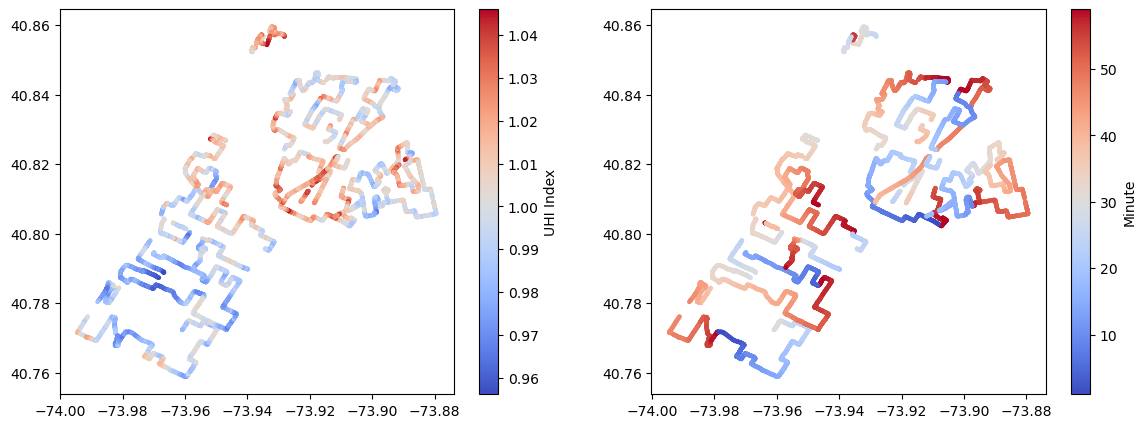

In [28]:
fig, (ax,ay) = plt.subplots(ncols=2, figsize=(14, 5))

sc1 = ax.scatter(df_training['Longitude'], df_training['Latitude'], c = df_training["UHI Index"], s = 5, cmap='coolwarm')
_ = plt.colorbar(sc1, ax=ax, label = "UHI Index")
sc2 = ay.scatter(df_training['Longitude'], df_training['Latitude'], c = df_training["datetime"].dt.minute, s = 5, cmap='coolwarm')
_ = plt.colorbar(sc2, ax=ay, label = "Minute")

-0.050115783644440706
-0.050115783644440706


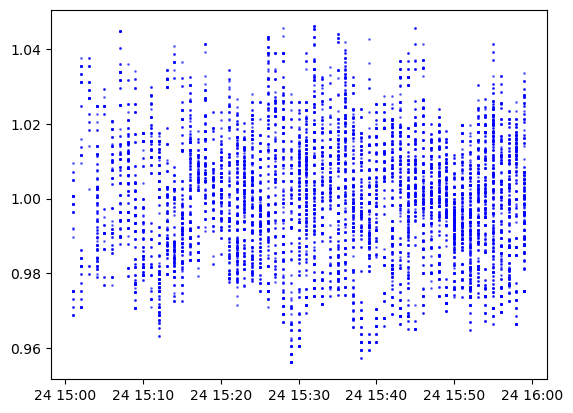

In [29]:
print(df_training["UHI Index"].corr(df_training["datetime"].dt.minute))
print(df_training["datetime"].dt.minute.corr(df_training["UHI Index"]))
_ = plt.plot(df_training["datetime"], df_training["UHI Index"], "ob", ms = 1, alpha = 0.5)

In [30]:
df_training["geometry"] = [Point(x, y) for x, y in zip(df_training["Longitude"], df_training["Latitude"])]
df_training["geometry"].value_counts()

geometry
POINT (-73.95712833 40.79023667)    1
POINT (-73.90916667 40.81310667)    1
POINT (-73.90918667 40.813045)      1
POINT (-73.909215 40.81297833)      1
POINT (-73.90924167 40.81290833)    1
                                   ..
POINT (-73.90954833 40.81194)       1
POINT (-73.90953 40.81198167)       1
POINT (-73.90952167 40.81203167)    1
POINT (-73.90949333 40.81209333)    1
POINT (-73.90947667 40.81216333)    1
Name: count, Length: 11229, dtype: int64

In [31]:
print(df_training.shape)

(11229, 5)


**No hay puntos iguales!**

## 3. Meteorological data

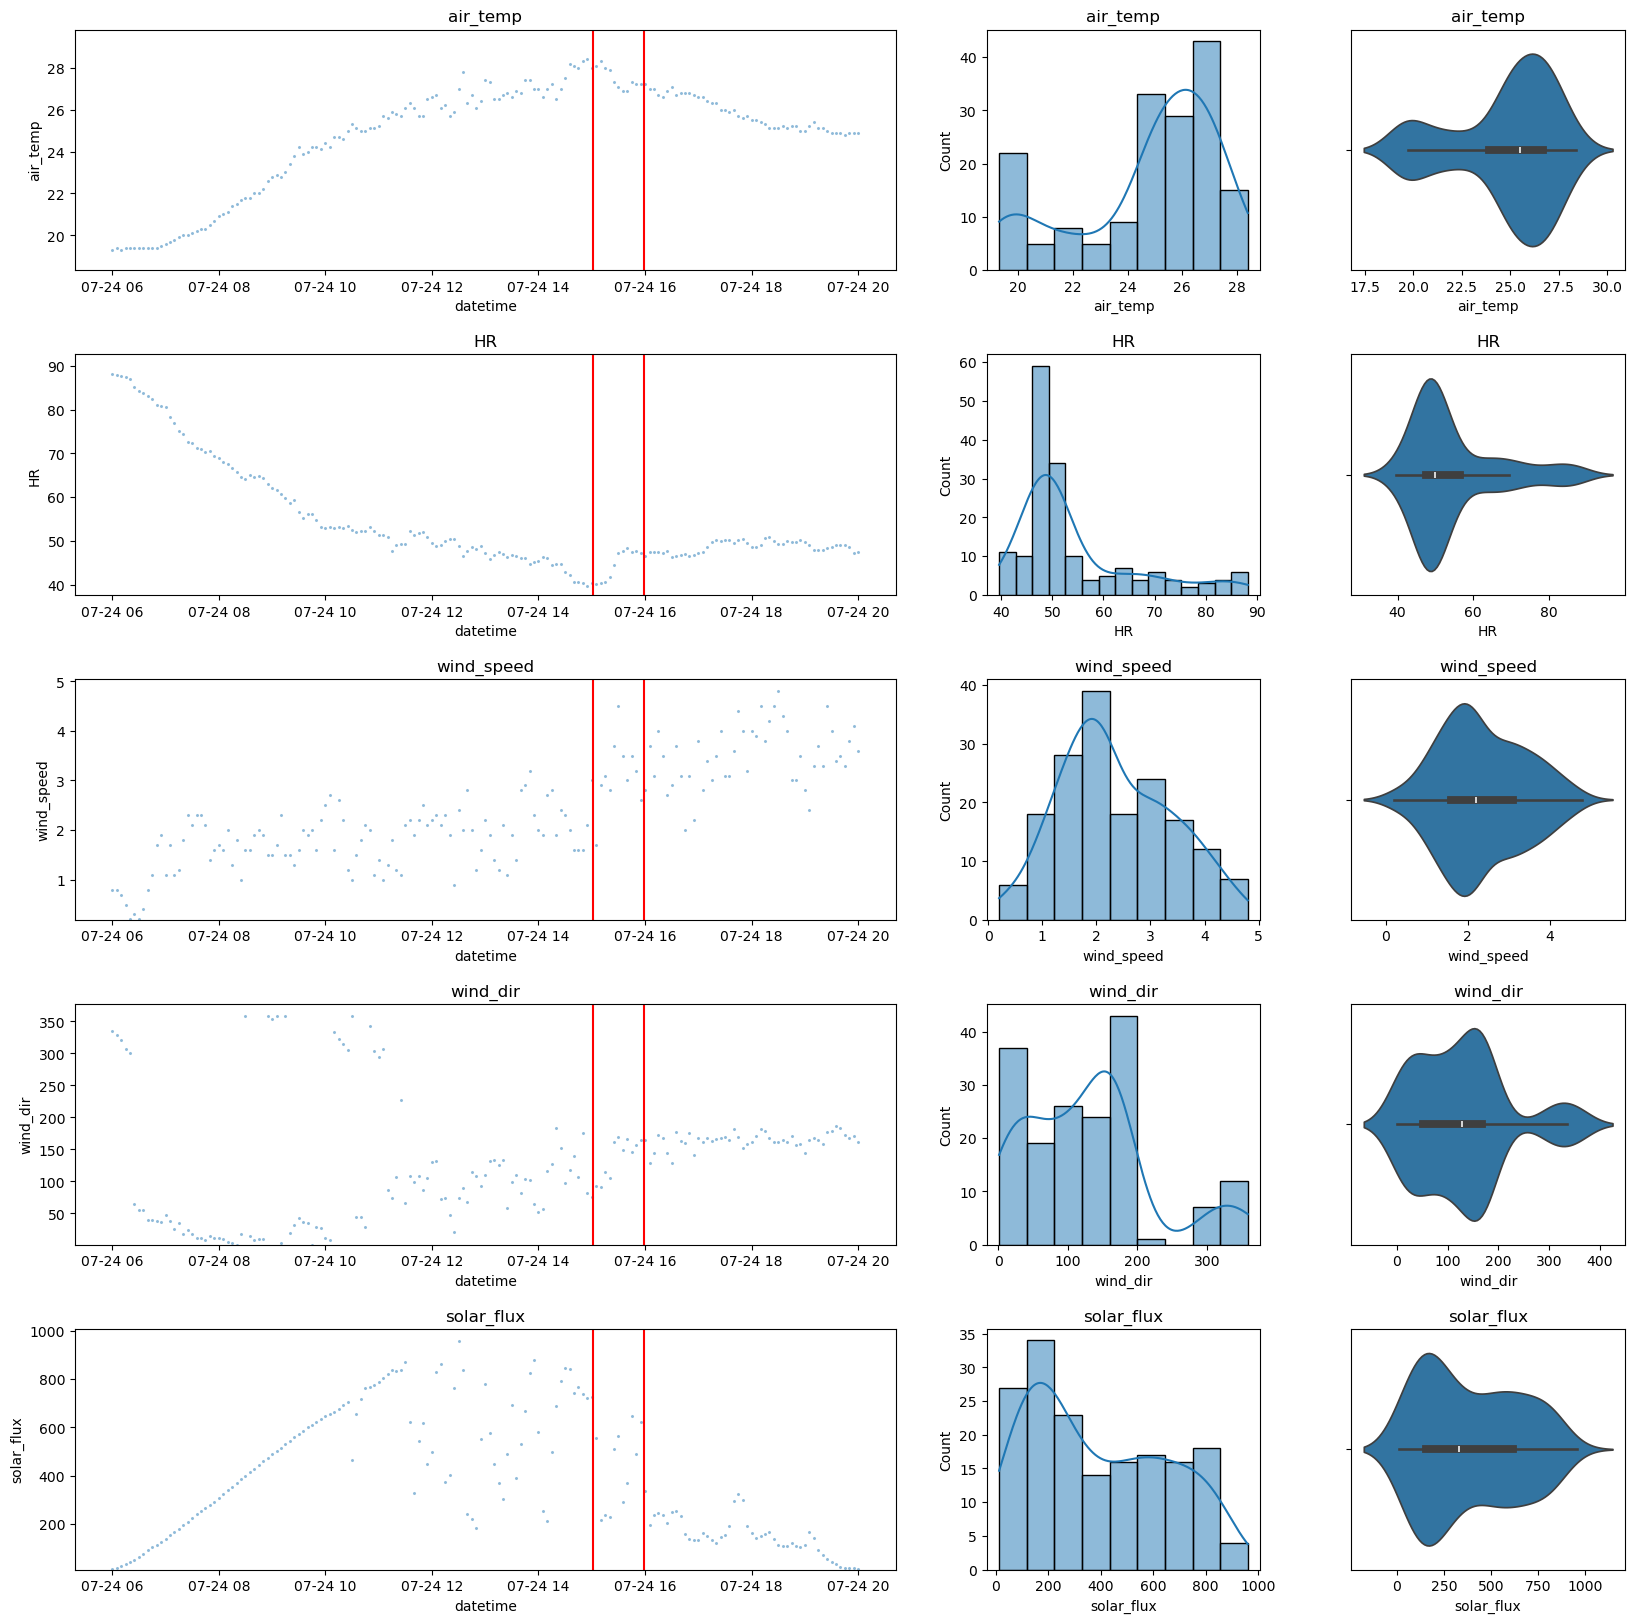

In [32]:
fig, ax = plt.subplots(ncols = 3, nrows = 5, figsize=(20, 20), gridspec_kw={"hspace":0.35}, width_ratios=[3, 1, 1])

sub_data = df_Bronx
for i, col in enumerate(sub_data.columns[1:-4]):
    sns.scatterplot(data=sub_data, x="datetime", y=col, ax=ax[i,0], alpha=0.5, s=5)
    ax[i,0].vlines(df_training["datetime"].min(), sub_data[col].min()*0.9, sub_data[col].max()*1.1, color='r', linestyle='-')
    ax[i,0].vlines(df_training["datetime"].max(), sub_data[col].min()*0.9, sub_data[col].max()*1.1, color='r', linestyle='-')
    ax[i,0].set_title(col)
    ax[i,0].set_ylim(sub_data[col].min()*0.95, sub_data[col].max()*1.05)
    sns.histplot(sub_data[col], ax=ax[i,1], kde=True)
    ax[i,1].set_title(col)
    sns.violinplot(data=sub_data, x=col, ax=ax[i,2])
    ax[i,2].set_title(col)

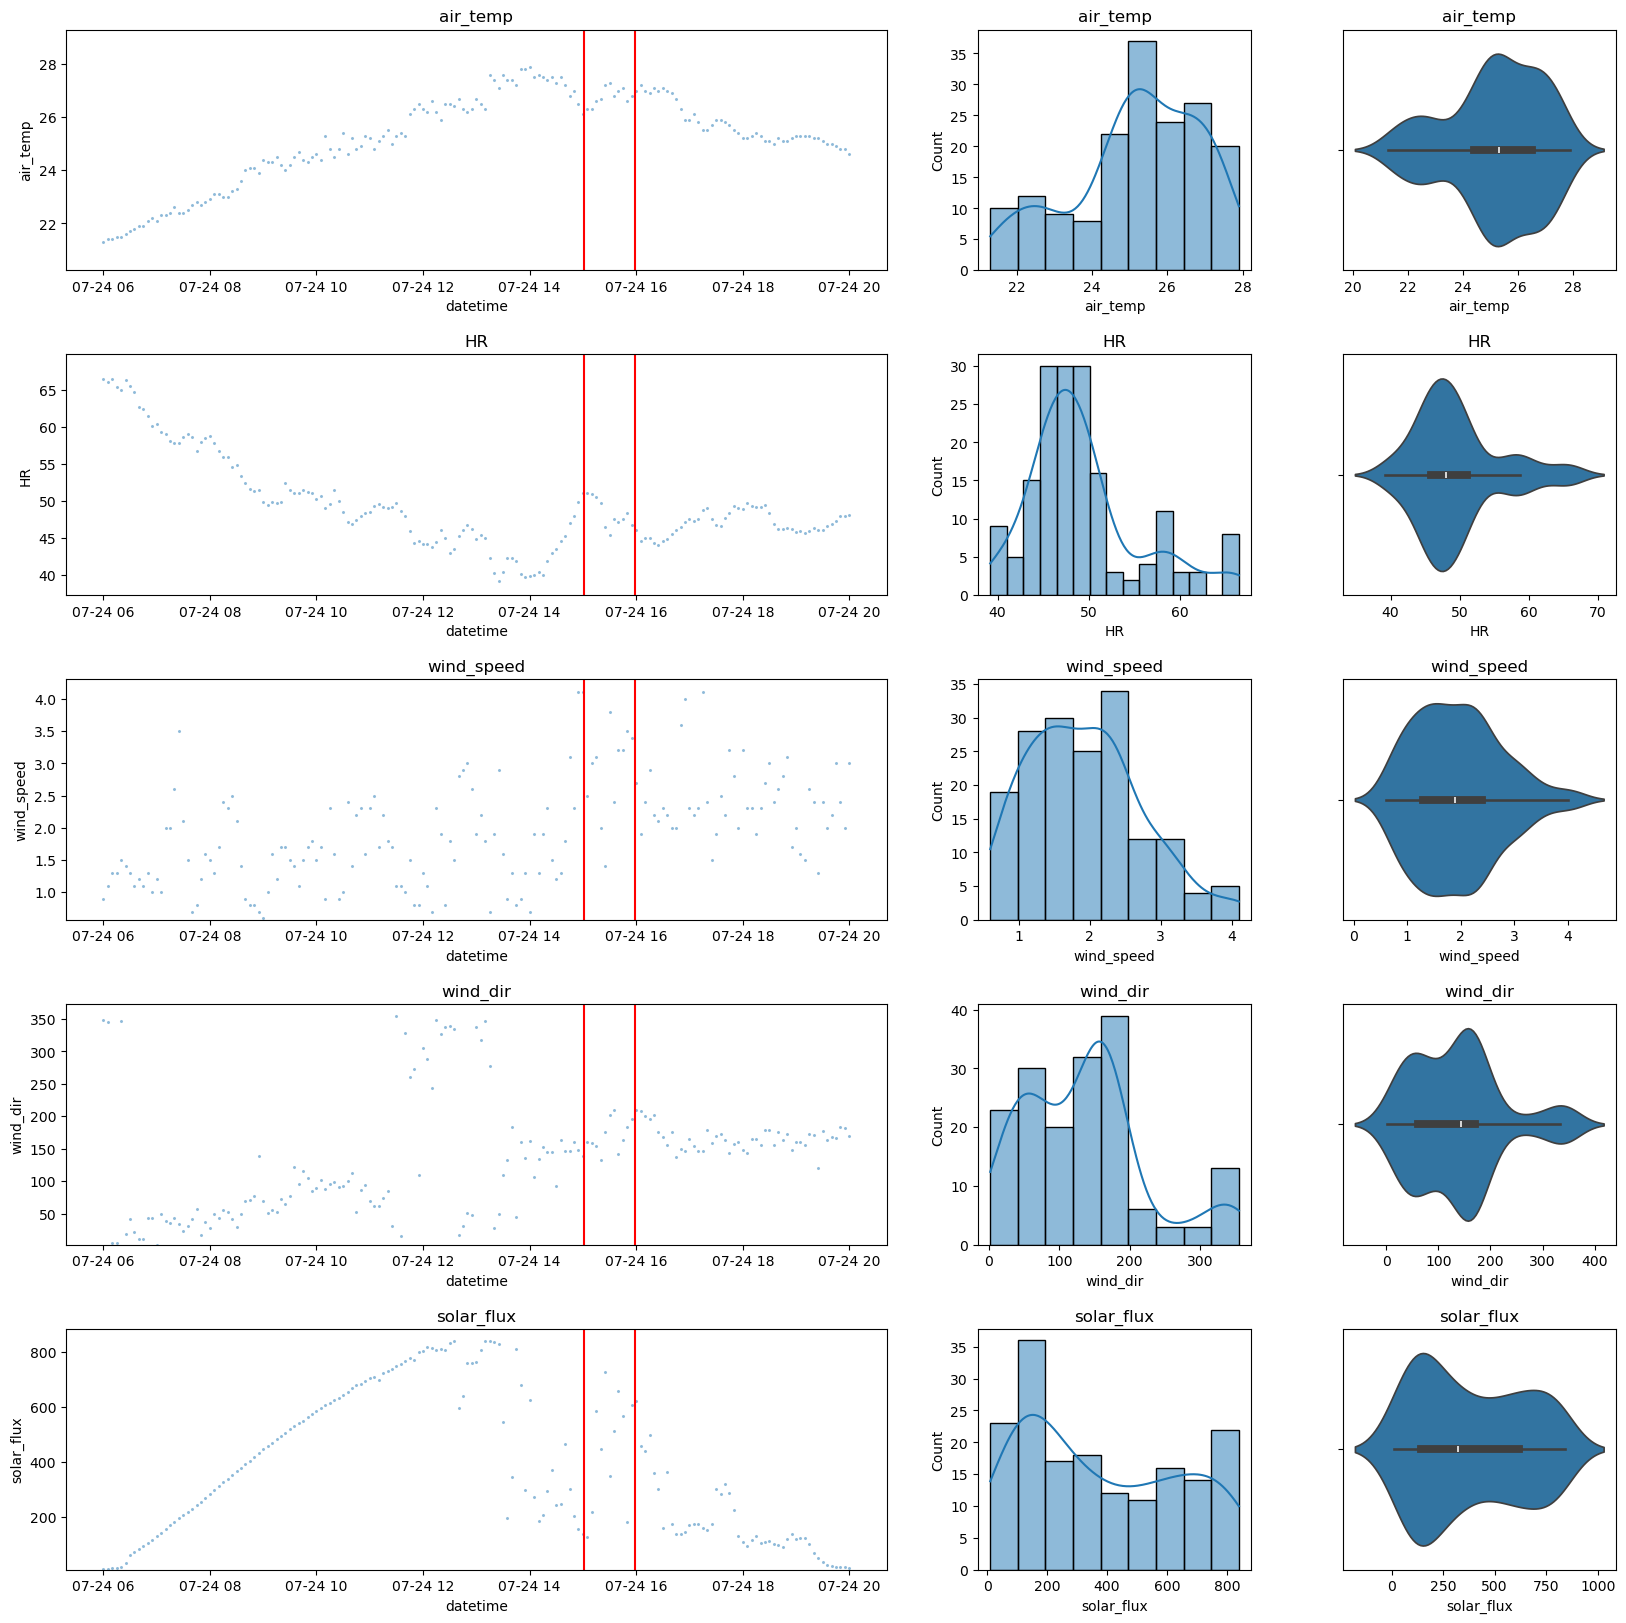

In [33]:
fig, ax = plt.subplots(ncols = 3, nrows = 5, figsize=(20, 20), gridspec_kw={"hspace":0.35}, width_ratios=[3, 1, 1])

sub_data = df_Manhattan
for i, col in enumerate(sub_data.columns[1:-4]):
    sns.scatterplot(data=sub_data, x="datetime", y=col, ax=ax[i,0], alpha=0.5, s=5)
    ax[i,0].vlines(df_training["datetime"].min(), sub_data[col].min()*0.9, sub_data[col].max()*1.1, color='r', linestyle='-')
    ax[i,0].vlines(df_training["datetime"].max(), sub_data[col].min()*0.9, sub_data[col].max()*1.1, color='r', linestyle='-')
    ax[i,0].set_title(col)
    ax[i,0].set_ylim(sub_data[col].min()*0.95, sub_data[col].max()*1.05)
    sns.histplot(sub_data[col], ax=ax[i,1], kde=True)
    ax[i,1].set_title(col)
    sns.violinplot(data=sub_data, x=col, ax=ax[i,2])
    ax[i,2].set_title(col)

In [34]:
mask_data           = (df_Bronx["datetime"] >= df_training["datetime"].min()) & (df_Bronx["datetime"] <= df_training["datetime"].max())
df_Bronx_masked     = df_Bronx[mask_data]
df_Manhattan_masked = df_Manhattan[mask_data]
df_meteo            = pd.concat([df_Bronx, df_Manhattan], axis=0).reset_index(drop=True)
df_meteo_masked     = pd.concat([df_Bronx_masked, df_Manhattan_masked], axis=0).reset_index(drop=True)
df_meteo_masked.head()

,datetime,air_temp,HR,wind_speed,wind_dir,solar_flux,Latitude,Longitude,Altitude,Place
0,2021-07-24 15:05:00,28.100,40.200,1.700,92,558,40.872,-73.894,57.500,Bronx
1,2021-07-24 15:10:00,28.300,40.300,2.900,91,216,40.872,-73.894,57.500,Bronx
2,2021-07-24 15:15:00,28.000,40.700,3.100,114,236,40.872,-73.894,57.500,Bronx
3,2021-07-24 15:20:00,27.900,41.800,2.800,105,229,40.872,-73.894,57.500,Bronx
4,2021-07-24 15:25:00,27.300,44.400,3.700,162,511,40.872,-73.894,57.500,Bronx


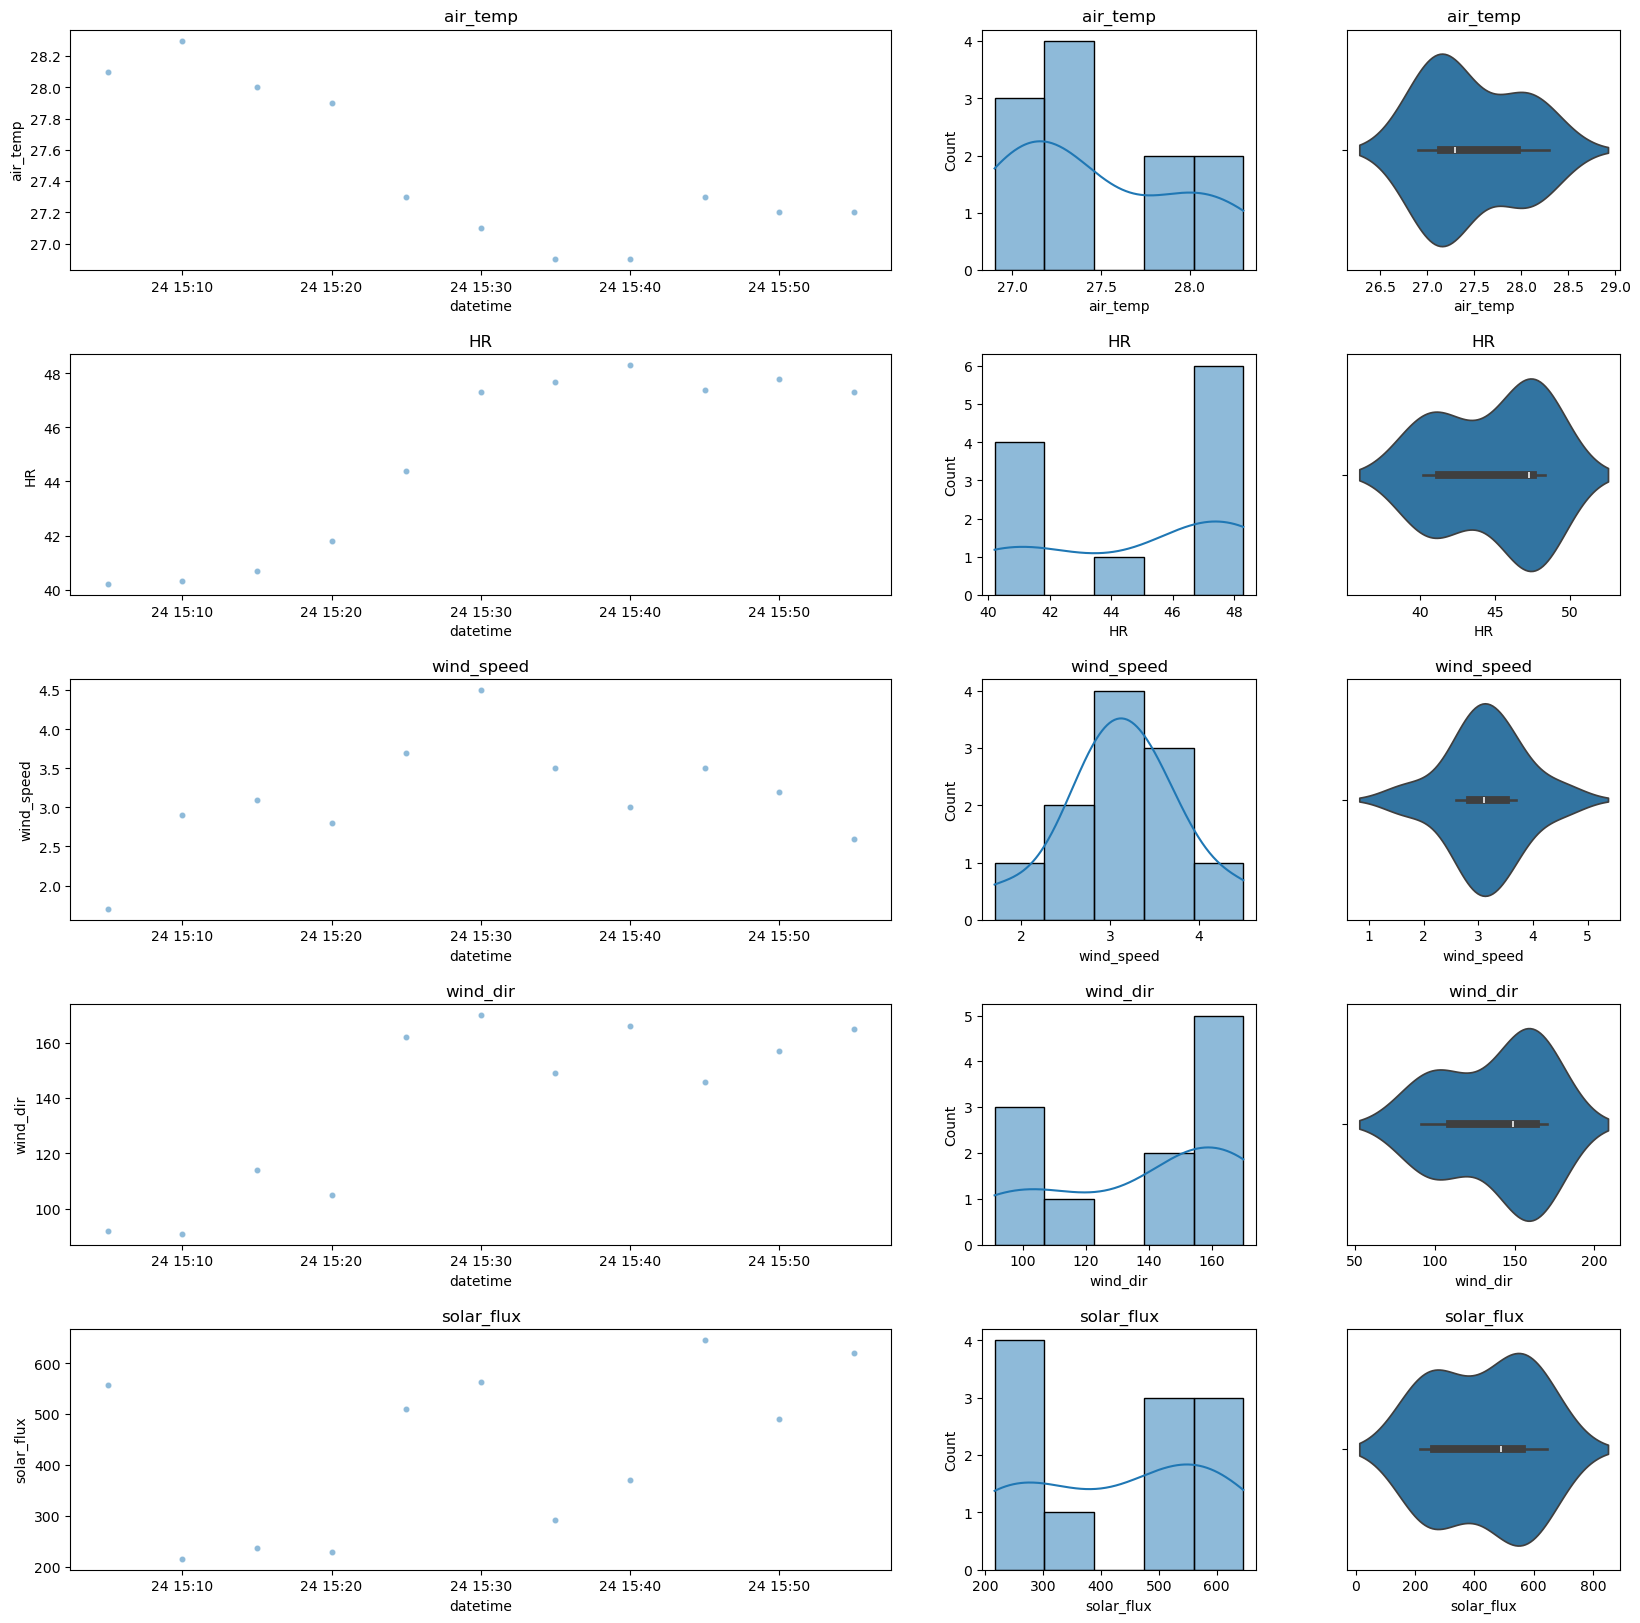

In [35]:
fig, ax = plt.subplots(ncols = 3, nrows = 5, figsize=(20, 20), gridspec_kw={"hspace":0.35}, width_ratios=[3, 1, 1])

sub_data = df_Bronx_masked
for i, col in enumerate(sub_data.columns[1:-4]):
    sns.scatterplot(data=sub_data, x="datetime", y=col, ax=ax[i,0], alpha=0.5, s=20)
    ax[i,0].set_title(col)
    sns.histplot(sub_data[col], ax=ax[i,1], kde=True)
    ax[i,1].set_title(col)
    sns.violinplot(data=sub_data, x=col, ax=ax[i,2])
    ax[i,2].set_title(col)

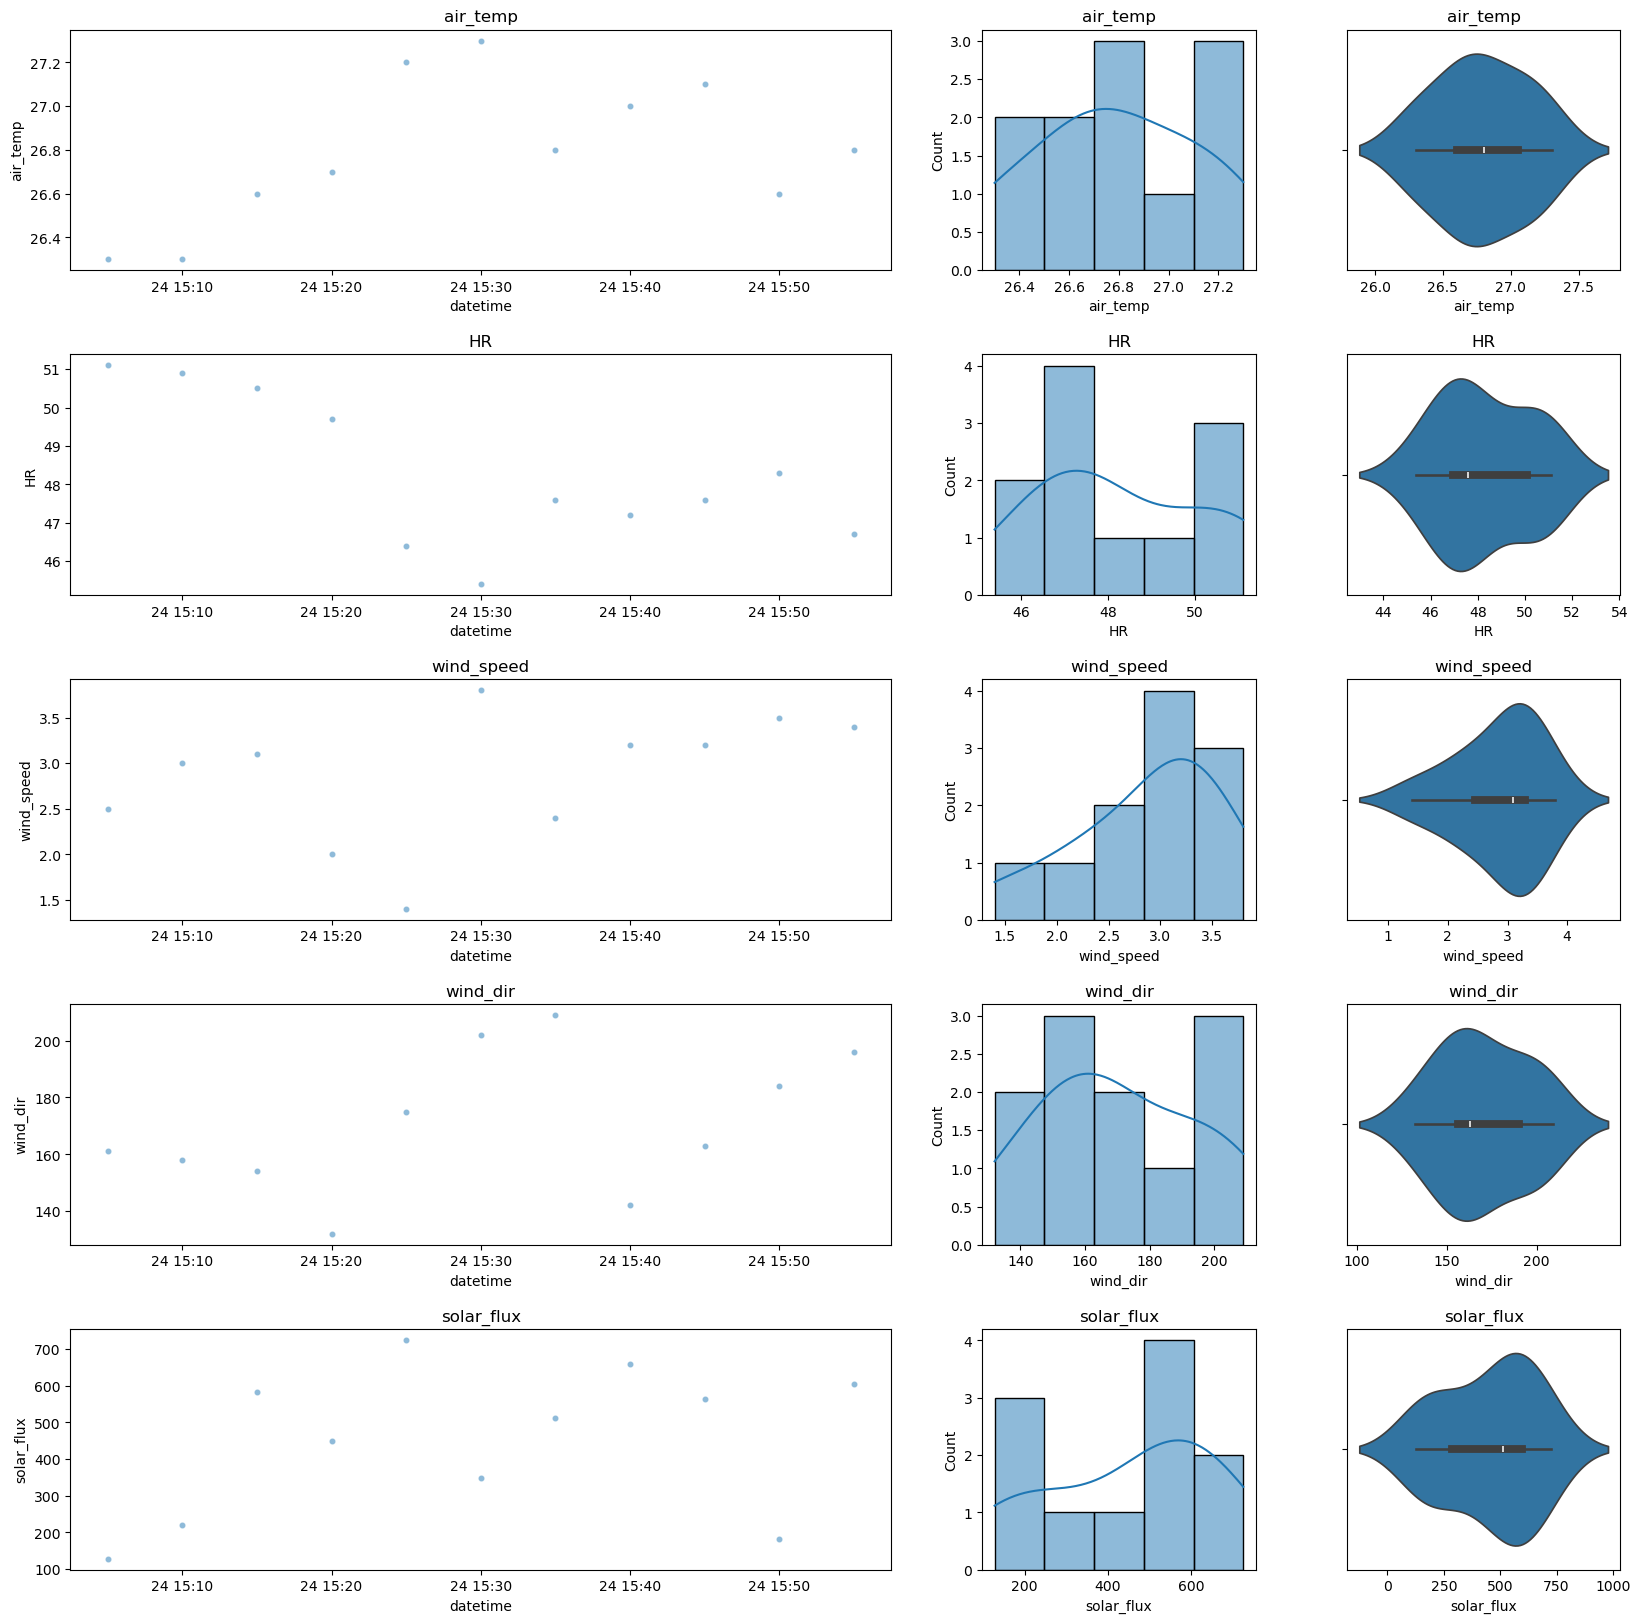

In [36]:
fig, ax = plt.subplots(ncols = 3, nrows = 5, figsize=(20, 20), gridspec_kw={"hspace":0.35}, width_ratios=[3, 1, 1])

sub_data = df_Manhattan_masked
for i, col in enumerate(sub_data.columns[1:-4]):
    sns.scatterplot(data=sub_data, x="datetime", y=col, ax=ax[i,0], alpha=0.5, s=20)
    ax[i,0].set_title(col)
    sns.histplot(sub_data[col], ax=ax[i,1], kde=True)
    ax[i,1].set_title(col)
    sns.violinplot(data=sub_data, x=col, ax=ax[i,2])
    ax[i,2].set_title(col)

## 4. Meteorological and raster relation

In [37]:
# raster_LST_new = raster_LST.assign_coords(band = ["LST"])
# raster_LST.close()

In [41]:
raster_S2_new = raster_S2.assign_coords(
    band = ("band", ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12']))
# raster_S2.close()

**generar propagación de variables con NDVI, NDBI y NDWI y variables climaticas entre 15:00 a 16:00**

In [39]:
def normalize(raster):
    return (raster - raster.min()) / (raster.max() - raster.min())

# raster_base = normalize(raster_base)
df_stations = df_meteo_masked

bounds = raster_S2_new.rio.bounds()
transform = raster_S2_new.rio.transform()

x_linspace = np.linspace(bounds[0], bounds[2], raster_S2_new.rio.width)
y_linspace = np.linspace(bounds[3], bounds[1], raster_S2_new.rio.height)
# 📌 Generar malla de coordenadas del raster
X, Y = np.meshgrid(
    x_linspace ,
    y_linspace
)

In [43]:
ndvi = (raster_S2_new.sel(band="B08") - raster_S2_new.sel(band="B04"))/ (raster_S2_new.sel(band="B08") + raster_S2_new.sel(band="B04"))
ndbi = (raster_S2_new.sel(band="B11") - raster_S2_new.sel(band="B08"))/ (raster_S2_new.sel(band="B11") + raster_S2_new.sel(band="B08"))
ndwi = (raster_S2_new.sel(band="B03") - raster_S2_new.sel(band="B08"))/ (raster_S2_new.sel(band="B03") + raster_S2_new.sel(band="B08"))

ndvi_norm = normalize(ndvi)
ndbi_norm = normalize(ndbi)
ndwi_norm = normalize(ndwi)

# 📌 Pesos de cada índice (ajustables según su relevancia)
w_ndvi = 3/6   # Mayor peso a NDVI porque relaciona vegetación y UHI
w_ndbi = 2/6   # Influencia de edificaciones
w_ndwi = 1/6   # Importancia del agua

# 📌 Calcular pesos combinados
pesos_indices = (w_ndvi * ndvi_norm + w_ndbi * ndbi_norm +
                 w_ndwi * ndwi_norm)

# 📌 Normalizar pesos combinados
pesos_indices /= pesos_indices.max()
pesos_indices = pesos_indices.astype(np.float16)

In [44]:
# 📌 Calcular distancias de cada píxel del raster a las estaciones
distancias = cdist(np.column_stack([X.ravel(), Y.ravel()]), df_stations[["Longitude", "Latitude"]].values)

# 📌 Invertir distancias (para ponderación)
pesos_distancia = 1 / (distancias + 1e-6)  # Evitar división por 0
pesos_distancia /= pesos_distancia.sum(axis=1, keepdims=True)  # Normalizar

# 📌 Combinamos distancia con los índices (pesos_indices)
alpha = 0.7  # Ajusta este valor (más alto => más peso a NDVI, NDBI, etc.)
pesos_combinados = alpha * pesos_indices.values.flatten()[:, np.newaxis] + (1 - alpha) * pesos_distancia
pesos_combinados /= pesos_combinados.sum(axis=1, keepdims=True)  # Normalizar

In [45]:
# 📌 Interpolar temperatura del aire considerando todos los índices
data_vars   = {}
dims        = {"y": len(y_linspace), "x": len(x_linspace)}
coords      = {
        "y": {"dims": ("y",), "data": y_linspace, "attrs": {"units": "°"}},
        "x": {"dims": ("x",), "data": x_linspace, "attrs": {"units": "°"}}
    }
for col in df_stations.columns[1:-4]:
    valor_interpolado = np.sum(pesos_combinados * df_stations[col].values, axis=1)
    # 📌 Convertir a forma de raster
    data_vars[col] = {"dims": ("y", "x"), "data": valor_interpolado.reshape(X.shape)}

d_ds = {
    "dims": dims ,
    "data_vars": data_vars,
    "coords": coords,
}

if isinstance(d_ds["coords"], tuple):
    # d_ds["coords"] = dict(d_ds["coords"])
    print("coords", type(d_ds["coords"]))  # Should be dict
if isinstance(d_ds["dims"], tuple):
    # d_ds["dims"] = dict(d_ds["dims"])
    print(type("dims", d_ds["dims"]))  # Should be dict
if isinstance(d_ds["data_vars"], tuple):
    # d_ds["data_vars"] = dict(d_ds["data_vars"])
    print("data_vars", type(d_ds["data_vars"]))  # Should be dict

In [46]:
raster_meteo = xr.Dataset.from_dict(d_ds)
raster_meteo = raster_meteo.rio.write_crs(4326)

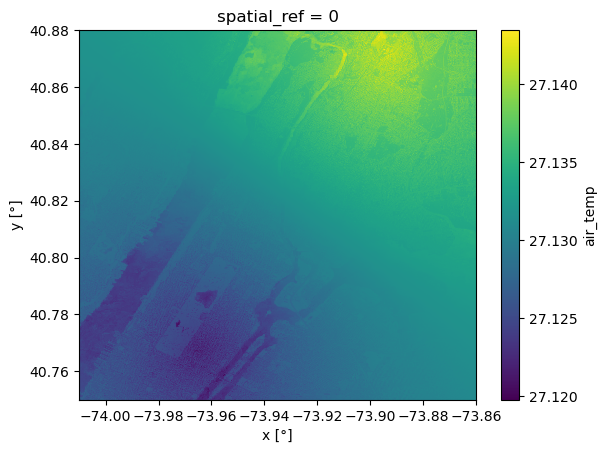

In [47]:
raster_meteo.air_temp.plot()

## Raster data

In [83]:
masked_raster_S2    = raster_S2#.rio.clip(gdf_kml.geometry, gdf_kml.crs, invert=True)
masked_raster_LST   = raster_LST#.rio.clip(gdf_kml.geometry, gdf_kml.crs, invert=True)
masked_meteo_data   = raster_meteo#.rio.clip(gdf_kml.geometry, gdf_kml.crs, invert=True)

## Extract information from raster data

In [89]:
latitudes, longitudes = df_training['Latitude'].values, df_training['Longitude'].values

Band_values = {}
# Assuming the correct dimensions are 'y' and 'x' (replace these with actual names from data.coords)
for i, text_band in enumerate(['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12']):
    Band_values_all = []
    for lat, lon in tqdm(zip(latitudes, longitudes), total=len(latitudes), desc="Mapping values Sentinel Band: "+text_band):
        Band_value_point = masked_raster_S2.sel(x=lon, y=lat, band=i, method="nearest").values
        Band_values_all.append(Band_value_point)
    Band_values[text_band] = Band_values_all

Band_values_all = []
for lat, lon in tqdm(zip(latitudes, longitudes), total=len(latitudes), desc="Mapping values Landsat"):
    Band_value_point = masked_raster_LST.sel(x=lon, y=lat, band=1, method="nearest").values
    Band_values_all.append(Band_value_point)
Band_values["LST"] = Band_values_all

for i, variables in enumerate(['air_temp', 'HR', 'wind_speed', 'wind_dir', 'solar_flux']):
    Band_values_all = []
    for lat, lon in tqdm(zip(latitudes, longitudes), total=len(latitudes), desc="Mapping values Meteorological: "+variables):
        Band_value_point = masked_meteo_data[variables].sel(x=lon, y=lat, method="nearest").values
        Band_values_all.append(Band_value_point)
    Band_values[variables] = Band_values_all

# Create a DataFrame to store the band values
result_training = pd.DataFrame.from_dict(Band_values).astype(np.float16)

result_training_concat = pd.concat([df_training, result_training], axis = 1)
result_training_concat["NDVI"]      = (result_training_concat["B08"] - result_training_concat["B04"]) / (result_training_concat["B08"] + result_training_concat["B04"]).replace([np.inf, -np.inf], np.nan)
result_training_concat["NDBI"]      = (result_training_concat["B11"] - result_training_concat["B08"]) / (result_training_concat["B11"] + result_training_concat["B08"]).replace([np.inf, -np.inf], np.nan)
result_training_concat["NDWI"]      = (result_training_concat["B03"] - result_training_concat["B08"]) / (result_training_concat["B03"] + result_training_concat["B08"]).replace([np.inf, -np.inf], np.nan)  
result_training_concat["SWIR_Diff"] = (result_training_concat["B11"] - result_training_concat["B12"]).replace([np.inf, -np.inf], np.nan)    # Diferencia SWIR

Mapping values Meteorological: solar_flux: 100%|██████████| 11229/11229 [00:20<00:00, 550.49it/s]


In [90]:
result_training_concat.isna().sum()

Longitude     0
Latitude      0
datetime      0
UHI Index     0
geometry      0
B01           0
B02           0
B03           0
B04           0
B05           0
B06           0
B07           0
B08           0
B8A           0
B09           0
B11           0
B12           0
LST           0
air_temp      0
HR            0
wind_speed    0
wind_dir      0
solar_flux    0
NDVI          0
NDBI          0
NDWI          0
SWIR_Diff     0
dtype: int64

In [91]:
result_training_concat.to_csv("../data/processed/training_data.csv", index=False)

In [94]:
latitudes_val, longitudes_val = df_validation['Latitude'].values, df_validation['Longitude'].values

Band_validation = {}
# Assuming the correct dimensions are 'y' and 'x' (replace these with actual names from data.coords)
for i, text_band in enumerate(['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12']):
    Band_validation_all = []
    for lat, lon in tqdm(zip(latitudes_val, longitudes_val), total=len(latitudes_val), desc="Mapping values Sentinel Band: "+text_band):
        Band_value_point = masked_raster_S2.sel(x=lon, y=lat, band=i, method="nearest").values
        Band_validation_all.append(Band_value_point)
    Band_validation[text_band] = Band_validation_all

Band_validation_all = []
for lat, lon in tqdm(zip(latitudes_val, longitudes_val), total=len(latitudes_val), desc="Mapping values Landsat"):
    Band_value_point = masked_raster_LST.sel(x=lon, y=lat, band=1, method="nearest").values
    Band_validation_all.append(Band_value_point)
Band_validation["LST"] = Band_validation_all

for i, variables in enumerate(['air_temp', 'HR', 'wind_speed', 'wind_dir', 'solar_flux']):
    Band_validation_all = []
    for lat, lon in tqdm(zip(latitudes_val, longitudes_val), total=len(latitudes_val), desc="Mapping values Meteorological: "+variables):
        Band_value_point = masked_meteo_data[variables].sel(x=lon, y=lat, method="nearest").values
        Band_validation_all.append(Band_value_point)
    Band_validation[variables] = Band_validation_all

# Create a DataFrame to store the band values
result_validation = pd.DataFrame.from_dict(Band_validation).astype(np.float16)

result_validation_concat = pd.concat([df_validation, result_validation], axis = 1)

result_validation_concat["NDVI"]      = (result_validation_concat["B08"] - result_validation_concat["B04"]) / (result_validation_concat["B08"] + result_validation_concat["B04"]).replace([np.inf, -np.inf], np.nan)
result_validation_concat["NDBI"]      = (result_validation_concat["B11"] - result_validation_concat["B08"]) / (result_validation_concat["B11"] + result_validation_concat["B08"]).replace([np.inf, -np.inf], np.nan)
result_validation_concat["NDWI"]      = (result_validation_concat["B03"] - result_validation_concat["B08"]) / (result_validation_concat["B03"] + result_validation_concat["B08"]).replace([np.inf, -np.inf], np.nan)  
result_validation_concat["SWIR_Diff"] = (result_validation_concat["B11"] - result_validation_concat["B12"]).replace([np.inf, -np.inf], np.nan)    # Diferencia SWIR

Mapping values Meteorological: solar_flux: 100%|██████████| 1040/1040 [00:01<00:00, 580.64it/s]


In [95]:
result_validation_concat.isna().sum()

Longitude        0
Latitude         0
UHI Index     1040
B01              0
B02              0
B03              0
B04              0
B05              0
B06              0
B07              0
B08              0
B8A              0
B09              0
B11              0
B12              0
LST              0
air_temp         0
HR               0
wind_speed       0
wind_dir         0
solar_flux       0
NDVI             0
NDBI             0
NDWI             0
SWIR_Diff        0
dtype: int64

In [96]:
result_validation_concat.to_csv("../data/processed/validation_data.csv", index=False)